In [8]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Meilleurs paramètres trouvés :  {'estimator__max_depth': 10, 'estimator__min_samples_split': 5, 'estimator__n_estimators': 100}
Meilleur score CV (neg MSE) :  -121.30118497804759
Target: temp_mean_c
  RMSE: 2.19
  R2: 0.91
------------------------------
Target: sunshine_duration_mean_hour
  RMSE: 0.79
  R2: 0.93
------------------------------
Target: ghi_mean_W_m2
  RMSE: 19.18
  R2: 0.95
------------------------------


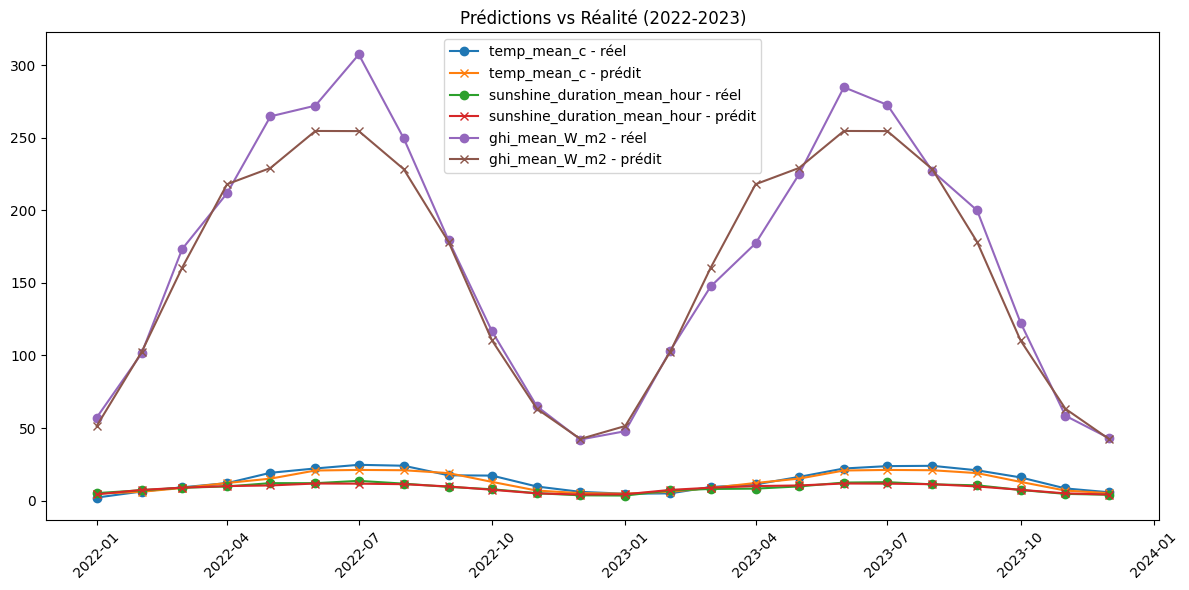

In [9]:

# 1. Charger les données météo sur Lyon sur 10 ans depuis un fichier CSV
df = pd.read_csv("datasets/lyon_meteo_10annees.csv")  # Remplace par le chemin réel de ton fichier

# 2. Supprimer certaines colonnes susceptibles de provoquer une fuite de données
# Ces colonnes contiennent probablement des informations liées directement à la cible ou calculées avec elle
cols_to_drop = ['panel_temp_c', 'correction_temp', 'energie_jour_kWh/j/m2', 'energie_mois_kWh/mois/m2']
df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])  # Drop seulement si la colonne existe

# 3. Créer une colonne 'date' à partir des colonnes 'year' et 'month_num' (le premier jour du mois)
df['date'] = pd.to_datetime(df[['year', 'month_num']].rename(columns={'month_num': 'month'}).assign(day=1))

# 4. Créer des features cycliques pour représenter le mois (utile pour modéliser la saisonnalité)
# On transforme le mois en deux variables sinusoïdales pour que 12 et 1 soient proches
df['month_sin'] = np.sin(2 * np.pi * df['month_num'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month_num'] / 12)

# 5. Sélectionner les colonnes caractéristiques (features) et les colonnes cibles (targets)
features = ['year', 'days_in_month', 'month_sin', 'month_cos']  # variables explicatives
targets = ['temp_mean_c', 'sunshine_duration_mean_hour', 'ghi_mean_W_m2']  # variables à prédire

X = df[features]  # données d'entrée
y = df[targets]   # données de sortie

# 6. Séparer les données en train/test selon l'année (split temporel)
# Toutes les données jusqu'à 2021 inclus vont dans l'ensemble d'entraînement
# Les données après 2021 seront utilisées pour tester le modèle
train_mask = df['year'] <= 2021
test_mask = df['year'] > 2021

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

# 7. Standardiser (normaliser) les features pour avoir moyenne 0 et écart-type 1
# Cela aide certains modèles à mieux converger
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # fit sur train + transform
X_test_scaled = scaler.transform(X_test)        # transform avec les mêmes paramètres

# 8. Créer un modèle multi-sortie avec un RandomForestRegressor de base
# MultiOutputRegressor permet de prédire simultanément plusieurs variables cibles
base_model = RandomForestRegressor(random_state=42)
multi_output_model = MultiOutputRegressor(base_model)

# 9. Définir une grille de recherche d'hyperparamètres pour optimiser le Random Forest
param_grid = {
    "estimator__n_estimators": [50, 100, 200],         # nombre d'arbres dans la forêt
    "estimator__max_depth": [5, 10, None],             # profondeur max des arbres
    "estimator__min_samples_split": [2, 5],            # nombre minimum d'échantillons pour diviser un noeud
}

# 10. Configuration du TimeSeriesSplit pour validation croisée adaptée aux données temporelles
# Le split respecte l'ordre chronologique pour éviter la fuite de données
tscv = TimeSeriesSplit(n_splits=5)

# 11. Lancer la recherche des meilleurs hyperparamètres avec GridSearchCV
# On évalue avec la métrique 'neg_mean_squared_error' (négatif car GridSearch maximise la métrique)
grid_search = GridSearchCV(
    estimator=multi_output_model,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,   # utilise tous les cœurs CPU disponibles
    verbose=2,   # affiche le détail de la progression
)
grid_search.fit(X_train_scaled, y_train)  # entraînement sur les données d'entraînement

# Afficher les meilleurs hyperparamètres trouvés et le score associé
print("Meilleurs paramètres trouvés : ", grid_search.best_params_)
print("Meilleur score CV (neg MSE) : ", grid_search.best_score_)

# 12. Entraîner le modèle final avec les meilleurs paramètres obtenus sur tout l'ensemble train
best_params = grid_search.best_params_
final_model = MultiOutputRegressor(
    RandomForestRegressor(
        n_estimators=best_params['estimator__n_estimators'],
        max_depth=best_params['estimator__max_depth'],
        min_samples_split=best_params['estimator__min_samples_split'],
        random_state=42
    )
)
final_model.fit(X_train_scaled, y_train)

# 13. Prédire les cibles sur l'ensemble de test
y_pred = final_model.predict(X_test_scaled)

# 14. Évaluer les performances sur le test set avec RMSE (erreur quadratique moyenne racine) et R2
for i, col in enumerate(targets):
    rmse = np.sqrt(mean_squared_error(y_test.iloc[:, i], y_pred[:, i]))
    r2 = r2_score(y_test.iloc[:, i], y_pred[:, i])
    print(f"Target: {col}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R2: {r2:.2f}")
    print("-" * 30)

# 15. Remplacer l'index du DataFrame y_test par la colonne 'date' pour un affichage lisible
y_test.index = df.loc[test_mask, 'date']

# 16. Visualiser les vraies valeurs vs les prédictions sur le test set
plt.figure(figsize=(12, 6))
for i, col in enumerate(targets):
    plt.plot(y_test.index, y_test.iloc[:, i], label=f"{col} - réel", marker='o')
    plt.plot(y_test.index, y_pred[:, i], label=f"{col} - prédit", marker='x')
plt.legend()
plt.title("Prédictions vs Réalité (2022-2023)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
#prédiction sur m+12

import calendar

# 1. Générer les dates futures (12 mois de 2025-08 à 2026-07)
future_dates = pd.date_range(start='2025-08-01', periods=12, freq='MS')  # MS = Month Start

# 2. Construire le DataFrame des features pour prédiction
future_df = pd.DataFrame({
    'year': future_dates.year,
    'month_num': future_dates.month,
})
# Ajouter days_in_month (nombre de jours dans chaque mois)
future_df['days_in_month'] = future_df.apply(lambda row: calendar.monthrange(row['year'], row['month_num'])[1], axis=1)

# Features cycliques
future_df['month_sin'] = np.sin(2 * np.pi * future_df['month_num'] / 12)
future_df['month_cos'] = np.cos(2 * np.pi * future_df['month_num'] / 12)

# 3. Sélectionner features
X_future = future_df[features]

# 4. Standardiser avec scaler déjà entraîné
X_future_scaled = scaler.transform(X_future)

# 5. Prédire
y_future_pred = final_model.predict(X_future_scaled)

# 6. Remettre dans un DataFrame pour lisibilité
predictions_future = pd.DataFrame(y_future_pred, columns=targets)
predictions_future['date'] = future_dates

df.rename(columns= {
    'temp_mean_c' : 'Température moyenne (°c)',
    'sunshine_duration_mean_hour' : "Durée d'ensoleillement moyenne (heure)",
    'ghi_mean_W_m2' : 'GHI moyen (W/m²)',
}, inplace=True)

predictions_future



,temp_mean_c,sunshine_duration_mean_hour,ghi_mean_W_m2,date
0,20.931580,11.317016,228.375634,2025-08-01
1,18.955456,9.757554,178.208013,2025-09-01
2,12.906131,7.455770,110.341856,2025-10-01
3,6.920222,4.987664,63.236234,2025-11-01
4,5.155377,4.186968,42.470513,2025-12-01
5,4.779806,4.354752,51.394480,2026-01-01
6,6.090321,7.375553,102.356055,2026-02-01
7,8.697930,8.913552,160.445727,2026-03-01
8,12.148105,10.010481,217.948905,2026-04-01
9,15.148225,10.451793,229.145195,2026-05-01
